In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#read kepler CSV
kepler_data = pd.read_csv("CSV/Kepler Load Presentation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read zeebe CSV
zeebe_data = pd.read_csv("CSV/Zeebe Load Presentation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

zeebe_data

,Job completion camunda8
Time,
2023-12-13 17:24:00,0.00
2023-12-13 17:24:30,0.00
2023-12-13 17:25:00,0.00
2023-12-13 17:25:30,8.17
2023-12-13 17:26:00,19.30
...,...
2023-12-13 19:58:00,0.00
2023-12-13 19:58:30,0.00
2023-12-13 19:59:00,0.00


In [23]:
completion_and_power = pd.DataFrame()

worker_cols = [col for col in kepler_data.columns if 'restworkerjava' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power['power'] = kepler_data[worker_cols].sum(axis=1)

# add job throughput
completion_and_power['completion'] = zeebe_data.iloc[:,0]

# filter out null values
completion_and_power = completion_and_power[completion_and_power['completion'].notnull() & completion_and_power['completion'] != 0]




<Axes: xlabel='Time'>

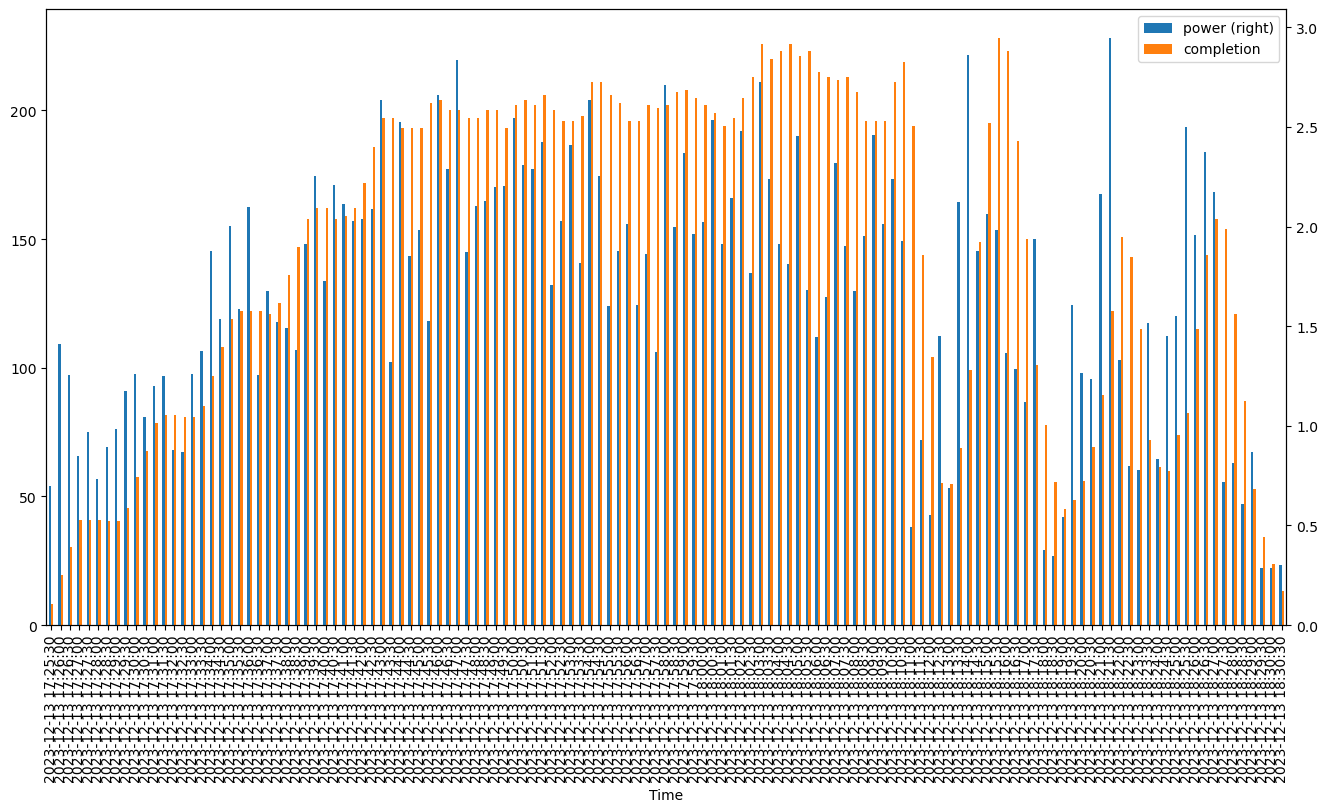

In [24]:
# plotting

figsize = [16, 8]

completion_and_power.plot(kind="bar", secondary_y='power', figsize=figsize)

In [27]:
# group in minute-long-buckets

measurements_per_minute = 2
amt_of_minutes = int(len(completion_and_power.index) / measurements_per_minute)

completion_and_power_per_min = pd.DataFrame()

for i in range(0, amt_of_minutes):
    completion_and_power_per_min[completion_and_power.index[i*measurements_per_minute]] = completion_and_power.iloc[i*measurements_per_minute:(i+1)*measurements_per_minute,:].sum(axis=0)

completion_and_power_per_min = completion_and_power_per_min.transpose()

completion_and_power_per_min

,power,completion
2023-12-13 17:25:30,2.1066,27.47
2023-12-13 17:26:30,2.1087,71.20
2023-12-13 17:27:30,1.6989,81.60
2023-12-13 17:28:30,1.8805,81.00
2023-12-13 17:29:30,2.4386,102.90
...,...,...
2023-12-13 18:25:30,4.4577,197.40
2023-12-13 18:26:30,4.5522,302.00
2023-12-13 18:27:30,1.5341,275.00
2023-12-13 18:28:30,1.4747,140.10


/tmp/ipykernel_82135/3428752206.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_tick_labels)


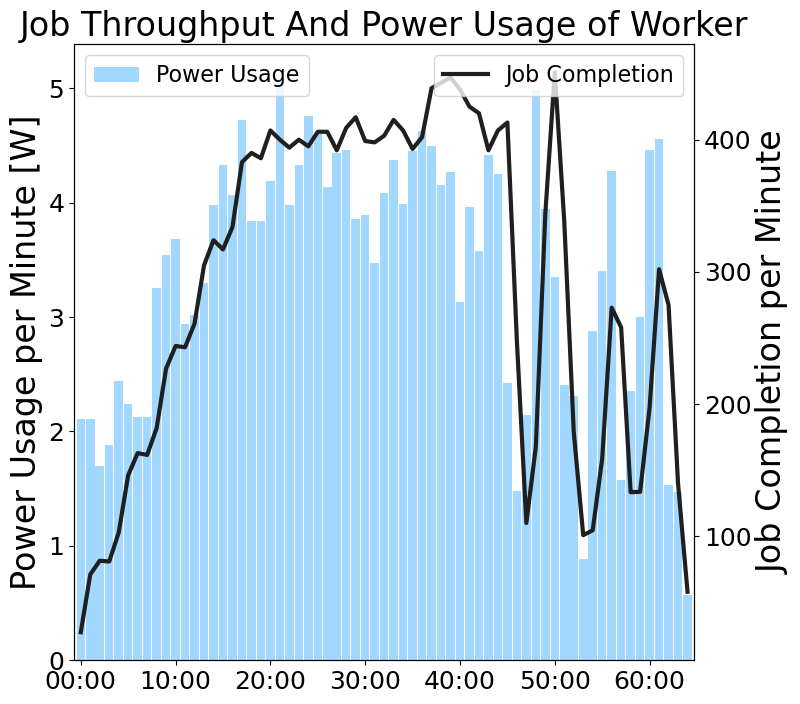

In [87]:
# Colors
lightgreen = "#6ccbb2"
green = "#437e6e"
darkblue = "#90c5e2"
blue = "#a2d8ff"
black= "#1f1f1f"
grey = "#f3f3f2"
white = "#ffffff"

colorlist = [ blue, green ]
figsize = [8,8]
x_tick_labels = [
    '00:00',
    '00:00',
    '10:00',
    '20:00',
    '30:00',
    '40:00',
    '50:00',
    '60:00'
]

ax = completion_and_power_per_min['power'].plot(kind="bar", color= blue, figsize=figsize, width=0.9)
ax_right = ax.twinx()
completion_and_power_per_min['completion'].plot(kind="line", color=black, linewidth = 3 , ax=ax_right)

ax.tick_params(labelsize=18, labelrotation=0)
ax.set_ylabel('Power Usage per Minute [W]', fontsize=24)
ax_right.tick_params(labelsize=18)
ax_right.set_ylabel('Job Completion per Minute', fontsize=24)

ax.legend(['Power Usage'], loc='upper left', fontsize = 16)
ax_right.legend(['Job Completion'], loc='upper right', fontsize = 16)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_ticklabels(x_tick_labels)
# ax.set_xticks(np.arange(0, len(completion_and_power_per_min.index)))
# ax_right.set_xticks(np.arange(0, len(completion_and_power_per_min.index)))
# ax_right.set_xticklabels(np.arange(0, len(completion_and_power_per_min.index)))

# ax = completion_and_power_per_min.plot(kind="bar", secondary_y='power', color= colorlist, figsize=figsize, width=0.7)
# completion_and_power_per_min.plot(kind="scatter", x='completion', y='power')
# completion_and_power.plot(kind="scatter", x='completion', y='power')

plt.title('Job Throughput And Power Usage of Worker', fontsize=24)
plt.show()

[[1.         0.70853367]
 [0.70853367 1.        ]]


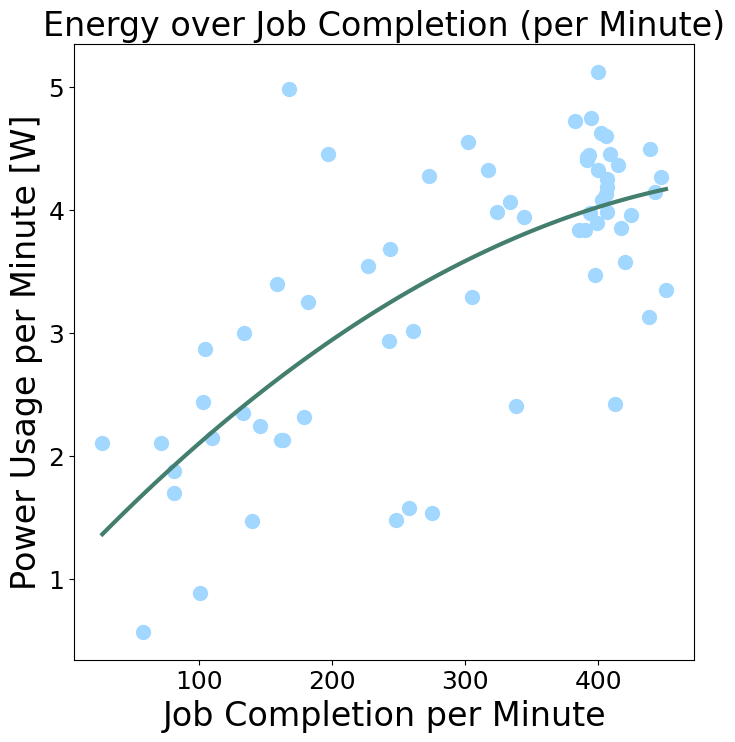

In [107]:
# quick regression curve

b, a = np.polyfit(completion_and_power_per_min['completion'], completion_and_power_per_min['power'], deg= 1)
r = np.corrcoef(completion_and_power_per_min['completion'], completion_and_power_per_min['power'])
xseq = np.linspace(0, int(completion_and_power_per_min['completion'].max()))

# 2nd degree regression curve

poly_degree = 2
params = np.polyfit(completion_and_power_per_min['completion'], completion_and_power_per_min['power'], poly_degree)
poly_eq = np.poly1d(params)
x_vals = np.linspace(completion_and_power_per_min['completion'].min(), completion_and_power_per_min['completion'].max(), 100)


ax = completion_and_power_per_min.plot(kind="scatter", x='completion', y='power', figsize=figsize,s=100, color= blue)

ax.tick_params(labelsize=18, labelrotation=0)
ax.set_ylabel('Power Usage per Minute [W]', fontsize=24)
ax.set_xlabel('Job Completion per Minute', fontsize=24)
ax_right.tick_params(labelsize=18)
ax_right.set_ylabel('Job Completion per Minute', fontsize=24)

# plot linear regression
# ax.plot(xseq, a + b * xseq, color=green, linewidth = 3);

# plot polynomial regression
ax.plot(x_vals, poly_eq(x_vals), color=green,  linewidth = 3, label=f'2nd Degree Fit')

plt.title('Energy over Job Completion (per Minute)', fontsize = 24)
print(r)
plt.show()

In [126]:
# divide the amount of power used by the number of jobs completed
watt_per_job = pd.DataFrame()

watt_per_job['power_pwer_worker'] = completion_and_power_per_min['power'] / completion_and_power_per_min['completion']
watt_per_job['completion'] = completion_and_power_per_min['completion']

r_per_worker = np.corrcoef(watt_per_job, watt_per_job.index)
print(r_per_worker)

# 2nd degree regression curve

poly_degree = 2
params = np.polyfit(watt_per_job.index, watt_per_job, poly_degree)
poly_eq = np.poly1d(params)
x_vals = np.linspace(watt_per_job.index.min(), watt_per_job.index.max(), 100)

watt_per_job = watt_per_job.sort_index()

ax = watt_per_job.plot(kind='scatter', x=watt_per_job.index, y=watt_per_job, figsize = [8,8], width= 0.7, color= blue, ylim=[0,0.04])

# plot polynomial regression
ax.plot(x_vals, poly_eq(x_vals), color=green,  linewidth = 3, label=f'2nd Degree Fit')

plt.show()

[[ 1.         -0.58810622]
 [-0.58810622  1.        ]]


ValueError: plot kind scatter can only be used for data frames